In [3]:
from google.colab import drive
drive.mount('/content/drive/')

import os
os.chdir('/content/drive/My Drive/Colab Notebooks/DeepShack/train')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [20]:
%load_ext autoreload
%autoreload 2

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.python.keras.layers import Conv2D
from tensorflow.python.keras.layers import MaxPooling2D
from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.python.keras.models import load_model

from image_handlers import ImageLoader, ShackCamLoader

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
new_shape = 120

In [6]:
model = Sequential([
  VGG16(weights='imagenet', include_top=False, input_shape=(new_shape, new_shape, 3)),
  Flatten(),
  Dropout(0.5),
  Dense(512, activation='relu'),
  Dropout(0.5),
  Dense(1, activation='linear')
])

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 2s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Total image samples 3878


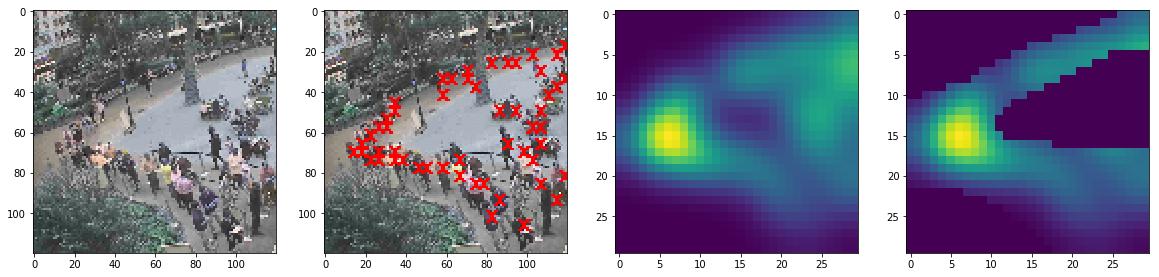

In [8]:
shackcam = ShackCamLoader(new_shape=new_shape, image_dir='data/shackcam')
shackcam.load_train_data()
shackcam.plot_image(i=500)
print('Total image samples', len(shackcam.count))

In [0]:
shape = (new_shape, new_shape)
mask = cv2.imread('data/shackcam/line_mask.png', 0) // 255
mask = cv2.resize(mask, shape)
mask = (mask == 0)

# tmp = []
# for img in shackcam.org_img:
#   img = img.copy()
#   img[mask] = 0
#   tmp.append(img)

  
# org_img = np.array(tmp)

# plt.imshow(org_img[0])

In [0]:
def mask_img(img):
  img = img.copy()
  img[mask] = 0
  return img

In [0]:
counts = pd.read_csv('data/shackcam/line_counts.csv', names=['file', 'line_count'], header=None)
counts = counts[counts.file.isin(shackcam.files)].reset_index(drop=True)
masked_img = np.array([mask_img(shackcam.data[f]['org_img']) for f in counts.file])

counts = counts.line_count.values

29

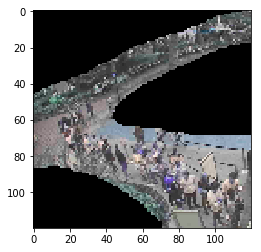

In [16]:
i = 6
plt.imshow(masked_img[i])
counts[i]

In [32]:
train_size = 0.8

x_train, x_test, y_train, y_test = train_test_split(masked_img, counts, train_size=train_size)

print('x_train', x_train.shape, 'x_test', x_test.shape)
print('y_train', y_train.shape, 'y_test', y_test.shape)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


x_train (3100, 120, 120, 3) x_test (776, 120, 120, 3)
y_train (3100,) y_test (776,)


In [0]:
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.001)
model.compile(optimizer=adam, loss='mse')
mc = ModelCheckpoint('results/vgg16_shackcam.h5', save_best_only=True)

model.fit(x_train, y_train, epochs=30, batch_size=128, 
          validation_split=0.1, verbose=1, callbacks=[mc])

scores = model.evaluate(x_test, y_test)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Instructions for updating:
Use tf.cast instead.
Train on 2790 samples, validate on 310 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
2790/2790 [==============================] - 1655s 593ms/sample - loss: 595.9114 - val_loss: 253.6342
Epoch 2/30
2790/2790 [==============================] - 1677s 601ms/sample - loss: 251.0006 - val_loss: 290.3154
Epoch 3/30
2790/2790 [==============================] - 1706s 611ms/sample - loss: 290.3917 - val_loss: 268.7178
Epoch 4/30
2790/2790 [==============================] - 1703s 610ms/sample - loss: 266.4883 - val_loss: 264.0613
Epoch 5/30
2790/2790 [==============================] - 1725s 618ms/sample - loss: 260.5972 - val_loss: 241.8811
Epoch 6/30
2790/2790 [==============================] - 1709s 613ms/sample - loss: 254.0110 - val_loss: 305.6121
Epoch 7/30
2790/2790 [==============================] - 1710s 613ms/sample - loss: 235.8146 - val_loss: 152.7086
Epoch 8/30
2790/2790 [==============================] - 1688s 605m

In [26]:
model = load_model('results/vgg16_shackcam.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


pred 20.841097 truth 17


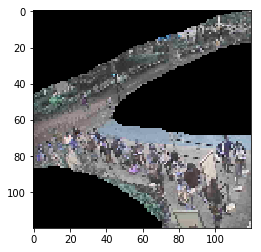

In [29]:
i = 2
plt.imshow(masked_img[i])

truth = counts[i]
pred = model.predict(np.expand_dims(masked_img[i], axis=0))[0][0]

print('pred', pred, 'truth', truth)